# Analysis of Accelerator-VC Bipartite Networks

Analysis of the USA accelerator-VC network using ecological metrics inspired by Theo's work on complex networks in entrepreneurial ecosystems.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import sys

sys.path.append('../../') 

# Import custom modules
from utils.data_cleaning import *
from utils.data_extraction import *
from utils.network_analysis import *

plt.style.use('default')
sns.set_palette('husl')

## Data Loading and Preparation

In [2]:
country = "france"
data_dir = f'../../data/{country}'

cleaned_data = load_clean_data(data_dir)

companies_clean = cleaned_data['companies']
investors_clean = cleaned_data['investors']
investments_clean = cleaned_data['investments']
funding_rounds_clean = cleaned_data['funding_rounds']

print(f"After cleaning:")
print(f"Companies: {len(companies_clean):,}")
print(f"Investors: {len(investors_clean):,}")
print(f"Investments: {len(investments_clean):,}")
print(f"Funding rounds: {len(funding_rounds_clean):,}")

After cleaning:
Companies: 2,361
Investors: 4,564
Investments: 10,163
Funding rounds: 14,375


## VC-Bipartite Network Construction

In [ ]:
vc_investments = extract_vc_investments(cleaned_data['investments'])

print("\nSample of VC investments:")
display_cols = ['company_name', 'investor_name', 'investor_types', 'total_funding_usd']
print(vc_investments[display_cols].head())

print("\VC-VC pairs:")
vc_vc_investments_pairs = create_investment_pairs(vc_investments, vc_investments, 'left_vc', 'right_vc')
vc_vc_investments_pairs['announced_year'] = vc_vc_investments_pairs[['announced_year_left_vc', 'announced_year_right_vc']].max(axis=1)
vc_vc_investments_pairs['total_funding_usd'] = (
    vc_vc_investments_pairs['total_funding_usd_left_vc']
    + vc_vc_investments_pairs['total_funding_usd_right_vc']
)
print(vc_vc_investments_pairs[['org_uuid', 'investor_name_left_vc', 'investor_name_right_vc']].head())

Found 5705 VC investments
Unique companies with VC funding: 1835

Sample of VC investments:
           company_name               investor_name  \
0                TVtrip  Balderton Capital-series_a   
1                TVtrip            Partech-series_a   
2                Twenga               3i Group-seed   
4                 MyFab              Alven-series_a   
6  Inspirational Stores      Atlas Venture-series_b   

                        investor_types  total_funding_usd  
0                      venture capital         13770000.0  
1                      venture capital         13770000.0  
2  private equity firm,venture capital         14790959.0  
4                      venture capital         10176279.0  
6                      venture capital         11470000.0  
\VC-VC pairs:
Created 19901 investment pairs
Covering 2815 unique investors
                                        org_uuid       investor_name_left_vc  \
0  a0f5e737-d973-703c-7f66-0fc31d0e4b5b-series_a  Balderton C

## Static Ecological Network Analysis

Analysis using ecological metrics inspired by Carniel's framework.

In [33]:
vc_vc_edges = extract_bipartite_edges_from_pairs(
    vc_vc_investments_pairs, 
    'investor_name_left_vc', 
    'investor_name_right_vc',
    'total_funding_usd'
)

# Bbipartite analysis with ecological metrics
network_analysis = analyze_bipartite_structure_robust(
    vc_vc_edges,
    'investor_name_left_vc',
    'investor_name_right_vc',
    'total_funding_usd',
    'Accelerators',
    'VCs',
    handle_overlap='suffix'
)

# Extract key metrics
basic_metrics = network_analysis['basic_metrics']
ecological_summary = network_analysis['ecological_summary']

print("=== Network Structure ===")
print(f"Nodes: {basic_metrics['num_nodes']} ({basic_metrics['set_0_size']} accelerators + {basic_metrics['set_1_size']} VCs)")
print(f"Edges: {basic_metrics['num_edges']}")
print(f"Density: {basic_metrics['density']:.3f}")
print(f"Components: {basic_metrics['num_components']}")

print("\n=== Ecological Metrics ===")
print(f"Connectance: {ecological_summary['connectance']:.3f}") # Or density
print(f"Nestedness (NODF): {ecological_summary['nestedness_nodf']:.1f}")
print(f"Modularity: {ecological_summary['modularity']:.3f}")

Overlapping nodes: ['Andurance Ventures-series_unknown', 'Oxford Capital-series_b', 'Oreo Finances-series_unknown', 'CICC-series_c', 'Crédit Mutuel Equity-series_unknown']...
Added suffixes to create pseudo-bipartite structure
=== Network Structure ===
Nodes: 4816 (2408 accelerators + 2408 VCs)
Edges: 13494
Density: 0.002
Components: 534

=== Ecological Metrics ===
Connectance: 0.002
Nestedness (NODF): 0.4
Modularity: 0.463


#### Comments

...

## Time Series Ecological Network Analysis

In [23]:
# Extract year from funding rounds for time series analysis
# Merge investment data with funding rounds to get temporal information
vc_vc_inv_pairs_ts = vc_vc_investments_pairs.copy()

# Convert to datetime and extract year
# vc_vc_inv_pairs_ts['announced_year'] = pd.to_datetime(vc_vc_inv_pairs_ts['announced_year'])
vc_vc_inv_pairs_ts['year'] = vc_vc_inv_pairs_ts['announced_year']

# Get the range of years
min_year = 2011
max_year = 2023

# Filter out rows with missing dates
vc_vc_inv_pairs_ts = vc_vc_inv_pairs_ts.dropna(subset=['year'])
vc_vc_inv_pairs_ts = vc_vc_inv_pairs_ts[(vc_vc_inv_pairs_ts['year'] >= min_year) & (vc_vc_inv_pairs_ts['year'] <= max_year)]


print(f"Time series analysis from {min_year} to {max_year}")
print(f"Total investments with dates: {len(vc_vc_inv_pairs_ts):,}")

# Show distribution by year
year_counts = vc_vc_inv_pairs_ts['year'].value_counts().sort_index()
print(f"\nInvestments per year:")
print(year_counts)

Time series analysis from 2011 to 2023
Total investments with dates: 17,411

Investments per year:
year
2011     143
2012     357
2013     404
2014     519
2015     891
2016     850
2017    1393
2018    1596
2019    1962
2020    1491
2021    3007
2022    2446
2023    2352
Name: count, dtype: int64


### Snapshot-based analysis

In [ ]:
# Initialize storage for time series metrics
time_series_metrics = []

# Minimum number of edges required for meaningful analysis
min_edges_threshold = 10

print("Computing ecological metrics for each year...")
print("=" * 50)

# Loop through each year and calculate metrics
for year in range(min_year, max_year + 1):
    cur_year_vc_vc_inv_pairs = vc_vc_inv_pairs_ts[vc_vc_inv_pairs_ts['year'] == year]

    if len(cur_year_vc_vc_inv_pairs) < min_edges_threshold:
        print(f"Year {year}: Skipping (only {len(cur_year_vc_vc_inv_pairs)} investments)")
        continue
    
    try:
        # Extract bipartite edges for this year
        year_edges = extract_bipartite_edges_from_pairs(
            cur_year_vc_vc_inv_pairs,
            'investor_name_acc',
            'investor_name_vc',
            'total_funding_usd'
        )

        # Analyze bipartite structure for this year
        year_analysis = analyze_bipartite_structure_robust(
            year_edges,
            'investor_name_acc',
            'investor_name_vc',
            'total_funding_usd',
            'VCs left',
            'VCs right',
            handle_overlap='suffix'
        )
        
        # Extract metrics
        basic_metrics = year_analysis['basic_metrics']
        ecological_summary = year_analysis['ecological_summary']
        
        # Store metrics for this year
        year_metrics = {
            'year': year,
            'num_nodes': basic_metrics['num_nodes'],
            'num_vcs_left': basic_metrics['set_0_size'],
            'num_vcs_right': basic_metrics['set_1_size'],
            'num_edges': basic_metrics['num_edges'],
            'density': basic_metrics['density'],
            'connectance': ecological_summary['connectance'],
            'nestedness_nodf': ecological_summary['nestedness_nodf'],
            'modularity': ecological_summary['modularity'],
            'cross_assortativity': ecological_summary['cross_assortativity'],
            'num_components': basic_metrics['num_components']
        }
        
        time_series_metrics.append(year_metrics)
        
        print(f"Year {year}: {basic_metrics['num_nodes']} nodes, {basic_metrics['num_edges']} edges, "
              f"Connectance: {ecological_summary['connectance']:.3f}, "
              f"Nestedness: {ecological_summary['nestedness_nodf']:.1f}, "
              f"Modularity: {ecological_summary['modularity']:.3f}")
        
    except Exception as e:
        print(f"Year {year}: Error - {str(e)}")
        continue

print(f"\nSuccessfully analyzed {len(time_series_metrics)} years")

Computing ecological metrics for each year...

VC-VC Network Structure:
  Unique VCs: 67
  Partnership edges: 93
  Network density: 0.042062
  Connected components: 46
  Density: 0.04206241519674356
Year 2011: 67 nodes, 93 edges, Connectance: 0.042, Components: 46.0, 

VC-VC Network Structure:
  Unique VCs: 100
  Partnership edges: 204
  Network density: 0.041212
  Connected components: 55
  Density: 0.041212121212121214
Year 2012: 100 nodes, 204 edges, Connectance: 0.041, Components: 55.0, 

VC-VC Network Structure:
  Unique VCs: 133
  Partnership edges: 222
  Network density: 0.025290
  Connected components: 79
  Density: 0.025290498974709502
Year 2013: 133 nodes, 222 edges, Connectance: 0.025, Components: 79.0, 

VC-VC Network Structure:
  Unique VCs: 177
  Partnership edges: 310
  Network density: 0.019902
  Connected components: 90
  Density: 0.01990241397021058
Year 2014: 177 nodes, 310 edges, Connectance: 0.020, Components: 90.0, 

VC-VC Network Structure:
  Unique VCs: 257
  Pa

In [25]:
# Convert to DataFrame for easier analysis and plotting
ts_df = pd.DataFrame(time_series_metrics)

if len(ts_df) > 0:
    print("Time Series Metrics Summary:")
    print(ts_df.describe().round(3))
    
    print(f"\nData available for years: {ts_df['year'].min()} to {ts_df['year'].max()}")
    print(f"Number of years analyzed: {len(ts_df)}")
else:
    print("No time series data available for analysis")

Time Series Metrics Summary:
           year  num_nodes  num_edges  connectance  num_components
count    13.000     13.000     13.000       13.000          13.000
mean   2017.000    308.308    701.538        0.018         121.077
std       3.894    150.543    447.763        0.011          41.001
min    2011.000     67.000     93.000        0.010          46.000
25%    2014.000    177.000    310.000        0.011          90.000
50%    2017.000    369.000    699.000        0.013         131.000
75%    2020.000    413.000    995.000        0.020         154.000
max    2023.000    521.000   1537.000        0.042         165.000

Data available for years: 2011 to 2023
Number of years analyzed: 13


Evolution of ecological metrics over time in the accelerator-VC ecosystem.

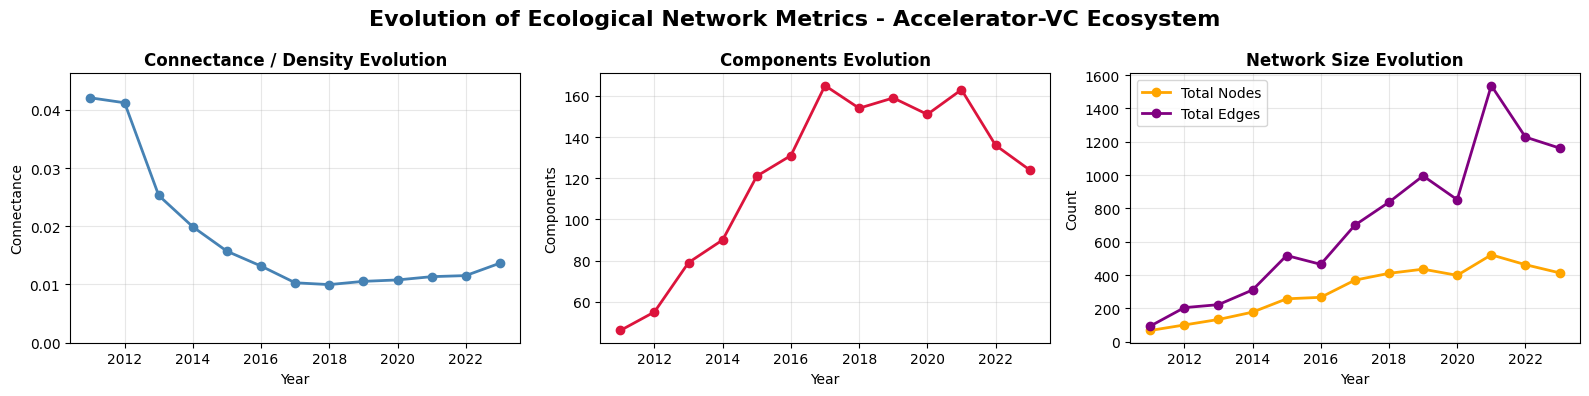

In [ ]:
if len(ts_df) > 0:
    # Create comprehensive time series plot
    fig, axes = plt.subplots(1, 5, figsize=(24, 4))
    fig.suptitle('Evolution of Ecological Network Metrics - VC-VC Ecosystem', 
                 fontsize=16, fontweight='bold')
    
    # Connectance evolution
    axes[0].plot(ts_df['year'], ts_df['connectance'], 'o-', linewidth=2, markersize=6, color='steelblue')
    axes[0].set_title('Connectance / Density Evolution', fontweight='bold')
    axes[0].set_xlabel('Year')
    axes[0].set_ylabel('Connectance')
    axes[0].grid(True, alpha=0.3)
    axes[0].set_ylim(0, max(ts_df['connectance']) * 1.1)
    
    # Nestedness evolution
    axes[1].plot(ts_df['year'], ts_df['nestedness_nodf'], 'o-', linewidth=2, markersize=6, color='forestgreen')
    axes[1].set_title('Nestedness (NODF) Evolution', fontweight='bold')
    axes[1].set_xlabel('Year')
    axes[1].set_ylabel('Nestedness (NODF)')
    axes[1].grid(True, alpha=0.3)
    
    # Modularity evolution
    axes[2].plot(ts_df['year'], ts_df['modularity'], 'o-', linewidth=2, markersize=6, color='crimson')
    axes[2].set_title('Modularity Evolution', fontweight='bold')
    axes[2].set_xlabel('Year')
    axes[2].set_ylabel('Modularity')
    axes[2].grid(True, alpha=0.3)
    
    # Network size evolution
    axes[3].plot(ts_df['year'], ts_df['num_nodes'], 'o-', linewidth=2, markersize=6, color='orange', label='Total Nodes')
    axes[3].plot(ts_df['year'], ts_df['num_edges'], 'o-', linewidth=2, markersize=6, color='purple', label='Total Edges')
    axes[3].set_title('Network Size Evolution', fontweight='bold')
    axes[3].set_xlabel('Year')
    axes[3].set_ylabel('Count')
    axes[3].legend()
    axes[3].grid(True, alpha=0.3)
    
    axes[4].plot(ts_df['year'], ts_df['num_accelerators'], 'o-', linewidth=2, markersize=6, 
                color='lightblue', label='Accelerators')
    axes[4].plot(ts_df['year'], ts_df['num_vcs'], 'o-', linewidth=2, markersize=6, 
                color='lightcoral', label='VCs')
    axes[4].set_title('Accelerators vs VCs Over Time', fontweight='bold')
    axes[4].set_xlabel('Year')
    axes[4].set_ylabel('Number of Actors')
    axes[4].legend()
    axes[4].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("No data available for time series visualization")

=== Temporal Trends Analysis ===

Year-over-Year Changes (average):
connectance: -0.0024 per year (total: -0.0284)
num_components: +6.5000 per year (total: +78.0000)
num_nodes: +28.8333 per year (total: +346.0000)
num_edges: +89.0833 per year (total: +1069.0000)


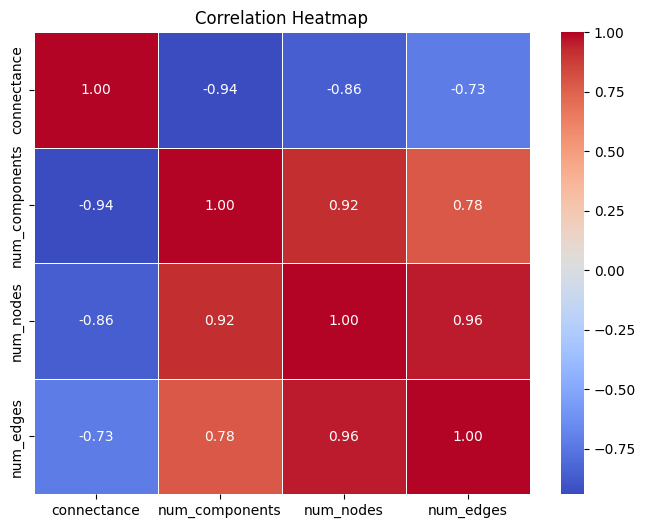

In [ ]:
if len(ts_df) > 1:
    # Calculate trends and correlations
    print("=== Temporal Trends Analysis ===")
    
    # Calculate year-over-year changes
    ts_df_sorted = ts_df.sort_values('year')
    
    metrics_to_analyze = ['connectance', 'nestedness_nodf', 'modularity', 'num_nodes', 'num_edges']
    
    print("\nYear-over-Year Changes (average):")
    for metric in metrics_to_analyze:
        if metric in ts_df_sorted.columns:
            # Calculate differences
            diffs = ts_df_sorted[metric].diff().dropna()
            avg_change = diffs.mean()
            total_change = ts_df_sorted[metric].iloc[-1] - ts_df_sorted[metric].iloc[0]
            print(f"{metric}: {avg_change:+.4f} per year (total: {total_change:+.4f})")
    
    # Correlation analysis
    print("\nCorrelations between metrics and time:")
    for metric in ['connectance', 'nestedness_nodf', 'modularity']:
        if metric in ts_df.columns:
            correlation = ts_df['year'].corr(ts_df[metric])
            trend_direction = "increasing" if correlation > 0.1 else "decreasing" if correlation < -0.1 else "stable"
            print(f"{metric}: r={correlation:.3f} ({trend_direction} trend)")
            
    matrix = ts_df_sorted[metrics_to_analyze].corr()

    plt.figure(figsize=(8,6))
    sns.heatmap(matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
    plt.title("Correlation Heatmap")
    plt.show()

else:
    print("Insufficient data for temporal trends analysis (need at least 2 years)")

### Cumulative network analysis (5 years window)

In [ ]:
# Initialize storage for time series metrics
ts_cumulative_metrics = []
cumulative_window = 5

# Minimum number of edges required for meaningful analysis
min_edges_threshold = 10

print(f"Computing ecological metrics for each year ({cumulative_window} years window)...")
print("=" * 50)

# Loop through each year and calculate metrics
for year in range(min_year, max_year + 1):
    cur_window_vc_vc_inv_pairs = vc_vc_inv_pairs_ts[(vc_vc_inv_pairs_ts['year'] >= year) & (vc_vc_inv_pairs_ts['year'] >= year - cumulative_window)]
    
    try:
        # Extract bipartite edges for this year
        window_edges = extract_bipartite_edges_from_pairs(
            cur_window_vc_vc_inv_pairs,
            'investor_name_acc',
            'investor_name_vc',
            'total_funding_usd'
        )
        
        # Analyze bipartite structure for this year
        window_analysis = analyze_bipartite_structure_robust(
            window_edges,
            'investor_name_acc',
            'investor_name_vc',
            'total_funding_usd',
            'VCs left',
            'VCs right',
            handle_overlap='suffix'
        )
        
        # Extract metrics
        cumulative_basic_metrics = window_analysis['basic_metrics']
        cumulative_eco_summary = window_analysis['ecological_summary']
        
        # Store metrics for this year
        cumulative_year_metrics = {
            'year': year,
            'num_nodes': cumulative_basic_metrics['num_nodes'],
            'num_vcs_left': cumulative_basic_metrics['set_0_size'],
            'num_vcs_right': cumulative_basic_metrics['set_1_size'],
            'num_edges': cumulative_basic_metrics['num_edges'],
            'density': cumulative_basic_metrics['density'],
            'connectance': cumulative_eco_summary['connectance'],
            'nestedness_nodf': cumulative_eco_summary['nestedness_nodf'],
            'modularity': cumulative_eco_summary['modularity'],
            'cross_assortativity': cumulative_eco_summary['cross_assortativity'],
            'num_components': cumulative_basic_metrics['num_components']
        }
        
        ts_cumulative_metrics.append(cumulative_year_metrics)
        
        print(f"Year {year}: {cumulative_basic_metrics['num_nodes']} nodes, {cumulative_basic_metrics['num_edges']} edges, "
              f"Connectance: {cumulative_eco_summary['connectance']:.3f}, "
              f"Nestedness: {cumulative_eco_summary['nestedness_nodf']:.1f}, "
              f"Modularity: {cumulative_eco_summary['modularity']:.3f}")
        
    except Exception as e:
        print(f"Year {year}: Error - {str(e)}")
        continue

print(f"\nSuccessfully analyzed {len(ts_cumulative_metrics)} years")

Computing ecological metrics for each year (5 years window)...

VC-VC Network Structure:
  Unique VCs: 2,142
  Partnership edges: 7,002
  Network density: 0.003054
  Connected components: 480
  Density: 0.003053626868776469
Year 2011: 2142 nodes, 7002 edges, Connectance: 0.003, Components: 480.0, 

VC-VC Network Structure:
  Unique VCs: 2,126
  Partnership edges: 6,955
  Network density: 0.003079
  Connected components: 475
  Density: 0.003078966299596038
Year 2012: 2126 nodes, 6955 edges, Connectance: 0.003, Components: 475.0, 

VC-VC Network Structure:
  Unique VCs: 2,084
  Partnership edges: 6,814
  Network density: 0.003139
  Connected components: 462
  Density: 0.003139389058487362
Year 2013: 2084 nodes, 6814 edges, Connectance: 0.003, Components: 462.0, 

VC-VC Network Structure:
  Unique VCs: 2,048
  Partnership edges: 6,697
  Network density: 0.003195
  Connected components: 451
  Density: 0.00319493847703957
Year 2014: 2048 nodes, 6697 edges, Connectance: 0.003, Components: 45

In [29]:
# Convert to DataFrame for easier analysis and plotting
ts_cumulative_df = pd.DataFrame(ts_cumulative_metrics)

if len(ts_cumulative_df) > 0:
    print("Time Series Metrics Summary:")
    print(ts_cumulative_df.describe().round(3))
    
    print(f"\nData available for years: {ts_cumulative_df['year'].min()} to {ts_cumulative_df['year'].max()}")
    print(f"Number of years analyzed: {len(ts_cumulative_df)}")
else:
    print("No time series data available for analysis")

Time Series Metrics Summary:
           year  num_nodes  num_edges  connectance  num_components
count    13.000     13.000     13.000       13.000          13.000
mean   2017.000   1610.077   5205.923        0.005         358.462
std       3.894    556.329   1896.635        0.003         115.298
min    2011.000    413.000   1162.000        0.003         124.000
25%    2014.000   1320.000   4177.000        0.003         289.000
50%    2017.000   1816.000   5920.000        0.004         393.000
75%    2020.000   2048.000   6697.000        0.005         451.000
max    2023.000   2142.000   7002.000        0.014         480.000

Data available for years: 2011 to 2023
Number of years analyzed: 13


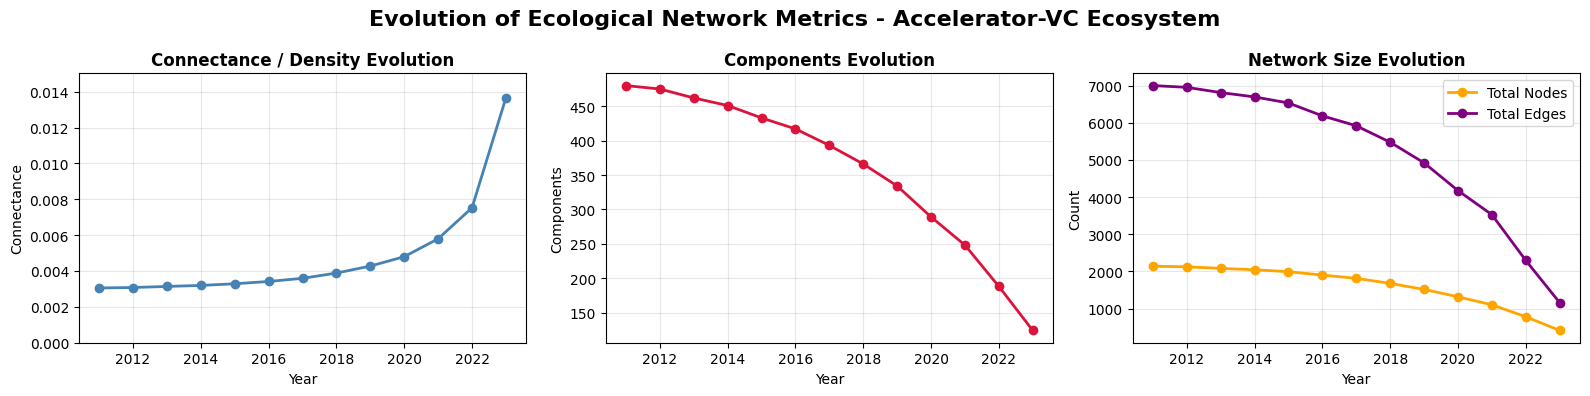

In [ ]:
if len(ts_cumulative_df) > 0:
    # Create comprehensive time series plot
    fig, axes = plt.subplots(1, 5, figsize=(20, 4))
    fig.suptitle('Evolution of Ecological Network Metrics - VC-VC Ecosystem', 
                 fontsize=16, fontweight='bold')
    
    # Connectance evolution
    axes[0].plot(ts_cumulative_df['year'], ts_cumulative_df['connectance'], 'o-', linewidth=2, markersize=6, color='steelblue')
    axes[0].set_title('Connectance / Density Evolution', fontweight='bold')
    axes[0].set_xlabel('Year')
    axes[0].set_ylabel('Connectance')
    axes[0].grid(True, alpha=0.3)
    axes[0].set_ylim(0, max(ts_cumulative_df['connectance']) * 1.1)
    
    # Nestedness evolution
    axes[1].plot(ts_cumulative_df['year'], ts_cumulative_df['nestedness_nodf'], 'o-', linewidth=2, markersize=6, color='forestgreen')
    axes[1].set_title('Nestedness (NODF) Evolution', fontweight='bold')
    axes[1].set_xlabel('Year')
    axes[1].set_ylabel('Nestedness (NODF)')
    axes[1].grid(True, alpha=0.3)
    
    # Modularity evolution
    axes[2].plot(ts_cumulative_df['year'], ts_cumulative_df['modularity'], 'o-', linewidth=2, markersize=6, color='crimson')
    axes[2].set_title('Modularity Evolution', fontweight='bold')
    axes[2].set_xlabel('Year')
    axes[2].set_ylabel('Modularity')
    axes[2].grid(True, alpha=0.3)
    
    # Network size evolution
    axes[3].plot(ts_cumulative_df['year'], ts_cumulative_df['num_nodes'], 'o-', linewidth=2, markersize=6, color='orange', label='Total Nodes')
    axes[3].plot(ts_cumulative_df['year'], ts_cumulative_df['num_edges'], 'o-', linewidth=2, markersize=6, color='purple', label='Total Edges')
    axes[3].set_title('Network Size Evolution', fontweight='bold')
    axes[3].set_xlabel('Year')
    axes[3].set_ylabel('Count')
    axes[3].legend()
    axes[3].grid(True, alpha=0.3)
    
    axes[4].plot(ts_cumulative_df['year'], ts_cumulative_df['num_vcs'], 'o-', linewidth=2, markersize=6, 
                color='lightblue', label='VCs left')
    axes[4].plot(ts_cumulative_df['year'], ts_cumulative_df['num_vcs'], 'o-', linewidth=2, markersize=6, 
                color='lightcoral', label='VCs right')
    axes[4].set_title('VCs vs VCs Over Time', fontweight='bold')
    axes[4].set_xlabel('Year')
    axes[4].set_ylabel('Number of Actors')
    axes[4].legend()
    axes[4].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("No data available for time series visualization")

=== Temporal Trends Analysis ===

Year-over-Year Changes (average):
connectance: +0.0009 per year (total: +0.0106)
num_components: -29.6667 per year (total: -356.0000)
num_nodes: -144.0833 per year (total: -1729.0000)
num_edges: -486.6667 per year (total: -5840.0000)


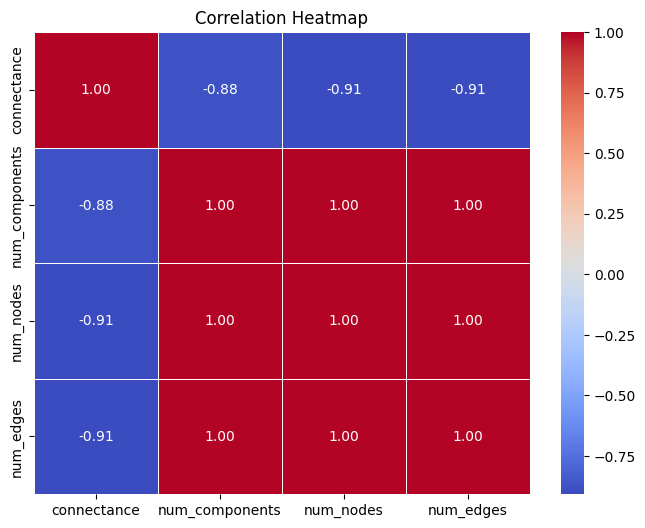

In [ ]:
if len(ts_cumulative_df) > 1:
    # Calculate trends and correlations
    print("=== Temporal Trends Analysis ===")
    
    # Calculate year-over-year changes
    ts_cumulative_df_sorted = ts_cumulative_df.sort_values('year')
    
    cumulative_metrics_to_analyze = ['connectance', 'nestedness_nodf', 'modularity', 'num_nodes', 'num_edges']
    
    print("\nYear-over-Year Changes (average):")
    for metric in cumulative_metrics_to_analyze:
        if metric in ts_cumulative_df_sorted.columns:
            # Calculate differences
            diffs = ts_cumulative_df_sorted[metric].diff().dropna()
            avg_change = diffs.mean()
            total_change = ts_cumulative_df_sorted[metric].iloc[-1] - ts_cumulative_df_sorted[metric].iloc[0]
            print(f"{metric}: {avg_change:+.4f} per year (total: {total_change:+.4f})")
    
    # Correlation analysis
    print("\nCorrelations between metrics and time:")
    for metric in ['connectance', 'nestedness_nodf', 'modularity']:
        if metric in ts_cumulative_df.columns:
            correlation = ts_cumulative_df['year'].corr(ts_cumulative_df[metric])
            trend_direction = "increasing" if correlation > 0.1 else "decreasing" if correlation < -0.1 else "stable"
            print(f"{metric}: r={correlation:.3f} ({trend_direction} trend)")
            
    cum_matrix = ts_cumulative_df_sorted[cumulative_metrics_to_analyze].corr()

    plt.figure(figsize=(8,6))
    sns.heatmap(cum_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
    plt.title("Correlation Heatmap")
    plt.show()

else:
    print("Insufficient data for temporal trends analysis (need at least 2 years)")